In [1]:
######################################################
#
# ReaSCAN: on the mission for AGI with language.
#
# Author: Zhengxuan Wu (wuzhengx@stanford.edu)
#
# Descriptions:
# This script is used as initial plannings for the 
# ReaSCAN engine. It illustrate how to integrate different
# parts together, such as Mini-Grid gym etc..
#
# Notes:
# 1. We will leverage gSCAN core engines but with extensive 
# modifications for ReaSCAN. This ensures fairness of 
# comparisions.
######################################################

In [2]:
from collections import namedtuple, OrderedDict
import itertools
import os
import numpy as np
from typing import Tuple
from typing import List
from typing import Dict
import random
from itertools import product
import copy
import re
import random

from utils import one_hot
from utils import generate_possible_object_names
from utils import numpy_array_to_image

from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *

### Vocabulary Module

In [3]:
# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["quickly", "slowly", "while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

In [4]:
# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()

### Situtation Module

In [5]:
# test out situation repr
TEST_SITUATION_1 = Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
                             target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                            position=Position(row=10, column=4),
                                                            vector=np.array([1, 0, 1])),
                             placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                                              position=Position(row=10, column=4),
                                                              vector=np.array([1, 0, 1])),
                                             PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                                              position=Position(row=3, column=12),
                                                              vector=np.array([0, 1, 0]))], carrying=None)
# TEST_SITUATION_1.to_representation()

In [6]:
# test out our new object definition
PositionedObject(object=Object(size=4, color='green', shape='box'),
                 position=Position(row=3, column=12),
                 vector=np.array([0, 1, 0]), overflow=True, overlap=True)

PositionedObject(object=Object(size=4, color='green', shape='box'), position=Position(column=12, row=3), vector=array([0, 1, 0]), overflow=True, overlap=True)

### World Module with Mini-Gym

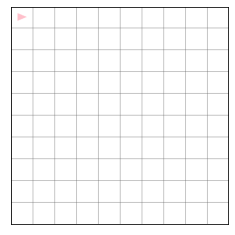

In [7]:
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
os.environ['QT_QPA_PLATFORM']='offscreen'
world = World(grid_size=10, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world_rgb = world.render_simple()

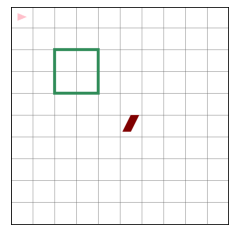

In [8]:
# try to place an object on to the map
world.clear_situation()
# world.place_object(Object(size=4, color="green", shape="box"), position=Position(row=3, column=3))
world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
world.place_object(Object(size=3, color="red", shape="cylinder"), position=Position(row=5, column=5))
_ = world.render_simple()

### ReaSCAN Grammer Module

In [9]:
grammer = Grammer(vocabulary)

In [10]:
grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2 ^ $OBJ_3 & $OBJ_4')

OrderedDict([('$OBJ_0', ['$OBJ_1', '$OBJ_2']),
             ('$OBJ_2', ['$OBJ_3', '$OBJ_4'])])

In [11]:
grammer.sample_object_relation_grammer(
    '$OBJ_0', 
    grammer.build_dependency_graph('$OBJ_0 ^ $OBJ_1 & $OBJ_2'))[:5]

[({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLUMN')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$IS_INSIDE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_SIZE')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_ROW'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_COLOR')])),
 ({'$OBJ_0': '$SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'},
  OrderedDict([(('$OBJ_0', '$OBJ_1'), '$SAME_COLUMN'),
               (('$OBJ_0', '$OBJ_2'), '$SAME_ROW')]))]

In [12]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_ROW', ('$OBJ_0', '$OBJ_2'): '$SAME_COLUMN'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
grammer.grounding_grammer_with_vocabulary(grammer_pattern, obj_pattern_map, rel_map)

[{'$OBJ_0': 'object', '$OBJ_1': 'circle', '$OBJ_2': 'cylinder'},
 {'$OBJ_0': 'object', '$OBJ_1': 'circle', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'cylinder', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'cylinder', '$OBJ_2': 'square'},
 {'$OBJ_0': 'object', '$OBJ_1': 'square', '$OBJ_2': 'circle'},
 {'$OBJ_0': 'object', '$OBJ_1': 'square', '$OBJ_2': 'cylinder'}]

### ReaSCAN Simulator

In [13]:
class ReaSCAN(object):
    """
    This contains a couple modules:
    (1) dataset generator.
    (2) dataset splitter.
    (3) dataset stats monitor.
    (4) dataset IO operator.
    (5) dataset tensorer.
    """
    def __init__(self):
        pass

In [14]:
class Simulator(object):
    """
    This convert generated grammers into a world/situation.
    
    Sample Situation:
    Situation(grid_size=15, agent_position=Position(row=7, column=2), agent_direction=INT_TO_DIR[0],
              target_object=PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                             position=Position(row=10, column=4),
                                             vector=np.array([1, 0, 1])),
              placed_objects=[PositionedObject(object=Object(size=2, color='red', shape='circle'),
                                               position=Position(row=10, column=4),
                                               vector=np.array([1, 0, 1])),
                              PositionedObject(object=Object(size=4, color='green', shape='circle'),
                                               position=Position(row=3, column=12),
                                               vector=np.array([0, 1, 0]))], carrying=None)
                                               
    Sample Placement in the World:
    world.place_object(Object(size=2, color="green", shape="box"), position=Position(row=2, column=2))
    
    """
    def __init__(self, object_vocabulary, vocabulary, grid_size=15, 
                 random_distractor_placement_max=5, relational_distractor_placement_max=1,
                 save_directory="./tmp/"):
        self.object_vocabulary = object_vocabulary
        self.vocabulary = vocabulary
        self.grid_size = grid_size
        self.random_distractor_placement_max = random_distractor_placement_max
        self.relational_distractor_placement_max  = relational_distractor_placement_max

        self._world = World(grid_size=grid_size, colors=vocabulary.get_semantic_colors(),
                            object_vocabulary=object_vocabulary,
                            shapes=vocabulary.get_semantic_shapes(),
                            save_directory=save_directory)
        self._world.clear_situation()
        
    def soft_sample_situations_from_grounded_grammer(self, grammer_pattern, 
                                                     obj_pattern_map, rel_map, obj_map, root="$OBJ_0"):
        """
        This is a soft placement, not actual placement.
        
        It is for adding distractors!
        """
        
        def soft_sample_position(grid_size, obj_row_map, obj_col_map):
            occupied_positions = []
            for k, v in obj_col_map.items():
                occupied_positions.append((obj_row_map[k], obj_col_map[k]))
            available_positions = [(row, col) for row, col in itertools.product(list(range(self.grid_size)),
                                                                                list(range(self.grid_size)))
                                   if (row, col) not in occupied_positions]
            sampled_position = random.sample(available_positions, 1).pop()
            return Position(row=sampled_position[0], column=sampled_position[1])

        def soft_position_taken(row, col):
            occupied_positions = []
            for k, v in obj_col_map.items():
                occupied_positions.append((obj_row_map[k], obj_col_map[k]))
            if (row, col) in occupied_positions:
                return True
            return False
        
        # first let us sample objects!
        sampled_objs = []
        obj_size_map = {}
        obj_color_map = {}
        obj_shape_map = {}
        obj_placed_map = {}
        obj_row_map = {}
        obj_col_map = {}
        obj_pos_map = {}
        obj_vector_map = {}
        for obj_grammer, obj_type in obj_map.items():
            obj_type = obj_type.split(" ")
            color = None
            size = None
            shape = None
            retry = 0
            while retry <= 10:
                retry += 1
                if len(obj_type) == 3:
                    size = obj_type[0]
                    color = obj_type[1]
                    shape = obj_type[2]
                elif len(obj_type) == 2:
                    if "$COLOR" in obj_pattern_map[obj_grammer]:
                        size = self.object_vocabulary.sample_size()
                        color = obj_type[0]
                        shape = obj_type[1]
                    elif "$SIZE" in obj_pattern_map[obj_grammer]:
                        size = obj_type[0]
                        color = self.object_vocabulary.sample_color()
                        shape = obj_type[1]
                elif len(obj_type) == 1:
                    size = self.object_vocabulary.sample_size()
                    color = self.object_vocabulary.sample_color()
                    shape = obj_type[0]
                # final handling for the shape
                if shape == "object":
                    shape = self.object_vocabulary.sample_shape()
                    
                # we need to override with relation if not root
                # only looking at size color shape, worry about
                # position later!
                if obj_grammer != root:
                    # go through the rel
                    for pair, rel in rel_map.items():
                        if obj_grammer == pair[-1]:
                            if pair[0] in obj_placed_map.keys():
                                # if this obj is acting as a child node
                                # then have to complain with parent node
                                if rel == "$SAME_SHAPE":
                                    shape = obj_shape_map[pair[0]]
                                elif rel == "$SAME_COLOR":
                                    color = obj_color_map[pair[0]]
                                elif rel == "$SAME_SIZE":
                                    size = obj_size_map[pair[0]]
                                elif rel == "$IS_INSIDE":
                                    # I think isinside is ok
                                    # we can just play around with
                                    # positions.
                                    pass
                    
                if (size, color, shape) not in sampled_objs:
                    # let us place this on to the world.
                    if obj_grammer == root:
                        obj_size_map[root] = size
                        obj_color_map[root] = color
                        obj_shape_map[root] = shape
                        obj_placed_map[root] = True
                        # we need to be brave and place it!
                        root_random_pos = soft_sample_position(self.grid_size, obj_row_map, obj_col_map)
                        obj_row_map[root] = root_random_pos.row
                        obj_col_map[root] = root_random_pos.column
                    else:
                        # we need to get a position
                        while True:
                            obj_random_pos = soft_sample_position(self.grid_size, obj_row_map, obj_col_map)
                            row = obj_random_pos.row
                            col = obj_random_pos.column
                            for pair, rel in rel_map.items():
                                if obj_grammer == pair[-1]:
                                    if pair[0] in obj_placed_map.keys():
                                        # if this obj is acting as a child node
                                        # then have to complain with parent node
                                        if rel == "$SAME_ROW":
                                            row = obj_row_map[pair[0]]
                                        elif rel == "$SAME_COLUMN":
                                            col = obj_col_map[pair[0]]
                                        elif rel == "$IS_INSIDE":
                                            # we need to make sure enclosure
                                            row_higher = min(obj_row_map[pair[0]], self.grid_size-size)
                                            col_higher = min(obj_col_map[pair[0]], self.grid_size-size)
                                            row_lower = max(obj_row_map[pair[0]]-(size-1), 0)
                                            col_lower = max(obj_col_map[pair[0]]-(size-1), 0)
                                            # consider the size and boundary as well
                                            row = random.randint(row_lower, row_higher)
                                            col = random.randint(col_lower, col_higher)

                            new_position=Position(row=row, column=col)
                            # box can overlap here!
                            if shape != "box":
                                if not soft_position_taken(row, col):
                                    break
                            else:
                                overlap_box = False
                                for exist_obj, exist_shape in obj_shape_map.items():
                                    if exist_shape == "box":
                                        if obj_row_map[exist_obj] == row or obj_col_map[exist_obj] == col:
                                            overlap_box = True
                                            break
                                if not overlap_box:
                                    break
                        obj_size_map[obj_grammer] = size
                        obj_color_map[obj_grammer] = color
                        obj_shape_map[obj_grammer] = shape
                        obj_placed_map[obj_grammer] = True
                        # we need to be brave and place it!
                        obj_row_map[obj_grammer] = new_position.row
                        obj_col_map[obj_grammer] = new_position.column 
                    sampled_objs.append((size, color, shape))
                    break
            if obj_grammer not in obj_placed_map.keys():
                return -1 # fail fast!
        # the second step is to sample distractors!!!
        current_plain_situation = {
            "obj_size_map" : obj_size_map,
            "obj_color_map" : obj_color_map,
            "obj_shape_map" : obj_shape_map,
            "obj_row_map" : obj_row_map,
            "obj_col_map" : obj_col_map
        }
        return current_plain_situation
        
    def sample_situations_from_grounded_grammer(self, grammer_pattern, 
                                                obj_pattern_map, rel_map, obj_map, root="$OBJ_0"):
        # maybe we dont need to use obj_pattern_map, let us see!
        self._world.clear_situation()
        # first let us sample objects!
        sampled_objs = []
        obj_size_map = {}
        obj_color_map = {}
        obj_shape_map = {}
        obj_placed_map = {}
        obj_row_map = {}
        obj_col_map = {}
        obj_pos_map = {}
        obj_vector_map = {}
        for obj_grammer, obj_type in obj_map.items():
            obj_type = obj_type.split(" ")
            color = None
            size = None
            shape = None
            while 1:
                if len(obj_type) == 3:
                    size = obj_type[0]
                    color = obj_type[1]
                    shape = obj_type[2]
                elif len(obj_type) == 2:
                    if "$COLOR" in obj_pattern_map[obj_grammer]:
                        size = self.object_vocabulary.sample_size()
                        color = obj_type[0]
                        shape = obj_type[1]
                    elif "$SIZE" in obj_pattern_map[obj_grammer]:
                        size = obj_type[0]
                        color = self.object_vocabulary.sample_color()
                        shape = obj_type[1]
                elif len(obj_type) == 1:
                    size = self.object_vocabulary.sample_size()
                    color = self.object_vocabulary.sample_color()
                    shape = obj_type[0]
                # final handling for the shape
                if shape == "object":
                    shape = self.object_vocabulary.sample_shape()
                    
                # we need to override with relation if not root
                # only looking at size color shape, worry about
                # position later!
                if obj_grammer != root:
                    # go through the rel
                    for pair, rel in rel_map.items():
                        if obj_grammer == pair[-1]:
                            if pair[0] in obj_placed_map.keys():
                                # if this obj is acting as a child node
                                # then have to complain with parent node
                                if rel == "$SAME_SHAPE":
                                    shape = obj_shape_map[pair[0]]
                                elif rel == "$SAME_COLOR":
                                    color = obj_color_map[pair[0]]
                                elif rel == "$SAME_SIZE":
                                    size = obj_size_map[pair[0]]
                                elif rel == "$IS_INSIDE":
                                    # I think isinside is ok
                                    # we can just play around with
                                    # positions.
                                    pass
                    
                if (size, color, shape) not in sampled_objs:
                    # let us place this on to the world.
                    if obj_grammer == root:
                        obj_size_map[root] = size
                        obj_color_map[root] = color
                        obj_shape_map[root] = shape
                        obj_placed_map[root] = True
                        # we need to be brave and place it!
                        root_random_pos = self._world.sample_position()
                        obj_row_map[root] = root_random_pos.row
                        obj_col_map[root] = root_random_pos.column
                        self._world.place_object(Object(size=size, color=color, shape=shape), 
                                                 position=root_random_pos, target=True)
                    else:
                        # we need to get a position
                        while True:
                            obj_random_pos = self._world.sample_position()
                            row = obj_random_pos.row
                            col = obj_random_pos.column
                            for pair, rel in rel_map.items():
                                if obj_grammer == pair[-1]:
                                    if pair[0] in obj_placed_map.keys():
                                        # if this obj is acting as a child node
                                        # then have to complain with parent node
                                        if rel == "$SAME_ROW":
                                            row = obj_row_map[pair[0]]
                                        elif rel == "$SAME_COLUMN":
                                            col = obj_col_map[pair[0]]
                                        elif rel == "$IS_INSIDE":
                                            # we need to make sure enclosure
                                            row_higher = min(obj_row_map[pair[0]], self.grid_size-size)
                                            col_higher = min(obj_col_map[pair[0]], self.grid_size-size)
                                            row_lower = max(obj_row_map[pair[0]]-(size-1), 0)
                                            col_lower = max(obj_col_map[pair[0]]-(size-1), 0)
                                            # consider the size and boundary as well
                                            row = random.randint(row_lower, row_higher)
                                            col = random.randint(col_lower, col_higher)

                            new_position=Position(row=row, column=col)
                            # box can overlap here!
                            if shape != "box":
                                if not self._world.position_taken(new_position):
                                    break
                            else:
                                overlap_box = False
                                for exist_obj, exist_shape in obj_shape_map.items():
                                    if exist_shape == "box":
                                        if obj_row_map[exist_obj] == row or obj_col_map[exist_obj] == col:
                                            overlap_box = True
                                            break
                                if not overlap_box:
                                    break
                        obj_size_map[obj_grammer] = size
                        obj_color_map[obj_grammer] = color
                        obj_shape_map[obj_grammer] = shape
                        obj_placed_map[obj_grammer] = True
                        # we need to be brave and place it!
                        obj_row_map[obj_grammer] = new_position.row
                        obj_col_map[obj_grammer] = new_position.column 
                        self._world.place_object(Object(size=size, color=color, shape=shape), 
                                                 position=new_position, target=False)
                        
                    sampled_objs.append((size, color, shape))
                    break
                    
        # the second step is to sample distractors!!!
        current_plain_situation = {
            "obj_size_map" : obj_size_map,
            "obj_color_map" : obj_color_map,
            "obj_shape_map" : obj_shape_map,
            "obj_row_map" : obj_row_map,
            "obj_col_map" : obj_col_map
        }
        if random.random() <= 0.5:
            self.place_relational_distractors(current_plain_situation, grammer_pattern, 
                                              obj_pattern_map, rel_map, obj_map)
        else:
            self.place_random_distractors(current_plain_situation, grammer_pattern, 
                                          obj_pattern_map, rel_map, obj_map)
        # agent position redo
        agent_position = self._world.sample_position()
        self._world.place_agent_at(agent_position)
        
        _ = self._world.render_simple()
        
    def place_relational_distractors(self, current_plain_situation, original_grammer_pattern, 
                                     original_obj_pattern_map, original_rel_map, original_obj_map, 
                                     root="$OBJ_0"):
        """
        This function brings reasonings into the next level of play!
        AI can solve this? :)
        
        TODO: destruct the obj map!
        """
        distractors_placed = 0 
        tries = 10
        dis_size_map = {}
        dis_color_map = {}
        dis_shape_map = {}
        dis_placed_map = {}
        dis_row_map = {}
        dis_col_map = {}
        dis_pos_map = {}
        total_distractor_count = 0
        for i in range(0, tries):
            if distractors_placed >= self.relational_distractor_placement_max:
                break
            # soft_sample_situations_from_grounded_grammer
            rel_map = copy.deepcopy(original_rel_map)
            obj_map = copy.deepcopy(original_obj_map)
            # must remove one of the main relation
            rand_idx = []
            rand_i = 0
            for pair, rel in rel_map.items():
                if pair[0] == root:
                    rand_idx.append(rand_i)
                rand_i += 1
            rel_idx = random.sample(rand_idx, 1).pop()
            old_rel = rel_map[list(rel_map.keys())[rel_idx]]
            new_rel = set(["$SAME_ROW", "$SAME_COLUMN", "$SAME_SHAPE", "$SAME_COLOR", "$SAME_SIZE"]) - set([old_rel])
            new_rel = list(new_rel)
            new_rel = random.sample(new_rel, 1).pop()
            rel_map[list(rel_map.keys())[rel_idx]] = new_rel

            if old_rel == "$IS_INSIDE":
                # we also need to remove box
                new_obj = random.sample(["circle", "square", "cylinder"], 1).pop()
                obj_map[list(rel_map.keys())[rel_idx][-1]] = new_obj
            

            distractor_plain_situation = self.soft_sample_situations_from_grounded_grammer(
                original_grammer_pattern, 
                original_obj_pattern_map, rel_map, obj_map, 
                root="$OBJ_0")

            if distractor_plain_situation != -1:
                valid_distractor = True
                for pair, rel in rel_map.items():
                    if distractor_plain_situation["obj_row_map"][pair[0]] \
                        == distractor_plain_situation["obj_row_map"][pair[1]] and "$SAME_ROW" == old_rel:
                        valid_distractor = False
                        break
                    if distractor_plain_situation["obj_col_map"][pair[0]] \
                        == distractor_plain_situation["obj_col_map"][pair[1]] and "$SAME_COLUMN" == old_rel:
                        valid_distractor = False
                        break
                    if distractor_plain_situation["obj_shape_map"][pair[0]] \
                        == distractor_plain_situation["obj_shape_map"][pair[1]] and "$SAME_SHAPE" == old_rel:
                        valid_distractor = False
                        break
                    if distractor_plain_situation["obj_size_map"][pair[0]] \
                        == distractor_plain_situation["obj_size_map"][pair[1]] and "$SAME_SIZE" == old_rel:
                        valid_distractor = False
                        break
                    if distractor_plain_situation["obj_color_map"][pair[0]] \
                        == distractor_plain_situation["obj_color_map"][pair[1]] and "$SAME_COLOR" == old_rel:
                        valid_distractor = False
                        break
                    if old_rel == "$IS_INSIDE":
                        box_row = distractor_plain_situation["obj_row_map"][pair[1]]
                        box_col = distractor_plain_situation["obj_col_map"][pair[1]]
                        box_size = distractor_plain_situation["obj_size_map"][pair[1]]
                        d_row = distractor_plain_situation["obj_row_map"][pair[0]]
                        d_col = distractor_plain_situation["obj_col_map"][pair[0]]
                        if d_row >= box_row and d_row < box_row + box_size and \
                            d_col >= box_col and d_col < box_col + box_size:
                            valid_distractor = False
                            break
                
                for k, v in distractor_plain_situation["obj_size_map"].items():
                    d_size = distractor_plain_situation["obj_size_map"][k]
                    d_color = distractor_plain_situation["obj_color_map"][k]
                    d_shape = distractor_plain_situation["obj_shape_map"][k]
                    d_row = distractor_plain_situation["obj_row_map"][k]
                    d_col = distractor_plain_situation["obj_col_map"][k]                    
                    
                    if not self.valid_distractor(d_size, d_color, d_shape, d_row, d_col, current_plain_situation,
                                                 grammer_pattern, obj_pattern_map, rel_map, obj_map, [old_rel]):
                        valid_distractor = False
                        break
                if valid_distractor:
                    distractors_placed += 1
                    for k, v in distractor_plain_situation["obj_size_map"].items():
                        dis_name = f"DIS_{total_distractor_count}"
                        d_size = distractor_plain_situation["obj_size_map"][k]
                        d_color = distractor_plain_situation["obj_color_map"][k]
                        d_shape = distractor_plain_situation["obj_shape_map"][k]
                        d_row = distractor_plain_situation["obj_row_map"][k]
                        d_col = distractor_plain_situation["obj_col_map"][k]
                        d_random_pos = Position(row=d_row, column=d_col)
                        dis_size_map[dis_name] = {d_size}
                        dis_color_map[dis_name] = {d_color}
                        dis_shape_map[dis_name] = {d_shape}
                        dis_row_map[dis_name] = {d_row}
                        dis_col_map[dis_name] = {d_col}
                        dis_pos_map[dis_name] = {d_random_pos}
                        self._world.place_object(Object(size=d_size, color=d_color, shape=d_shape), 
                                             position=d_random_pos, target=False)
        return {
            "dis_size_map" : dis_size_map,
            "dis_color_map" : dis_color_map,
            "dis_shape_map" : dis_shape_map,
            "dis_row_map" : dis_row_map,
            "dis_col_map" : dis_col_map
        }
    
    def valid_distractor(self, d_size, d_color, d_shape, d_row, d_col, current_plain_situation,
                         grammer_pattern, obj_pattern_map, rel_map, obj_map, old_rel=None, root="$OBJ_0"):
        if old_rel is not None:
            # if one, fail!
            for pair, rel in rel_map.items():
                if pair[0] == root:
                    if d_row == current_plain_situation["obj_row_map"][pair[1]] and "$SAME_ROW" in old_rel:
                        return False
                    if d_col == current_plain_situation["obj_col_map"][pair[1]] and "$SAME_COLUMN" in old_rel:
                        return False
                    if d_shape == current_plain_situation["obj_shape_map"][pair[1]] and "$SAME_SHAPE" in old_rel:
                        return False
                    if d_size == current_plain_situation["obj_size_map"][pair[1]] and "$SAME_SIZE" in old_rel:
                        return False
                    if d_color == current_plain_situation["obj_color_map"][pair[1]] and "$SAME_COLOR" in old_rel:
                        return False
                    if old_rel == "$IS_INSIDE":
                        box_row = current_plain_situation["obj_row_map"][pair[1]]
                        box_col = current_plain_situation["obj_col_map"][pair[1]]
                        box_size = current_plain_situation["obj_size_map"][pair[1]]
                        if d_row >= box_row and d_row < box_row + box_size and \
                            d_col >= box_col and d_col < box_col + box_size:
                            return False

        valid_distractor = False
        for pair, rel in rel_map.items():
            if pair[0] == root:
                # the distractor cannot pertain the relation with the child node
                if rel == "$SAME_ROW":
                    if d_row != current_plain_situation["obj_row_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$SAME_COLUMN":
                    if d_col != current_plain_situation["obj_col_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$SAME_SHAPE":
                    if d_shape != current_plain_situation["obj_shape_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$SAME_COLOR":
                    if d_color != current_plain_situation["obj_color_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$SAME_SIZE":
                    if d_size != current_plain_situation["obj_size_map"][pair[1]]:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                elif rel == "$IS_INSIDE":
                    box_row = current_plain_situation["obj_row_map"][pair[1]]
                    box_col = current_plain_situation["obj_col_map"][pair[1]]
                    box_size = current_plain_situation["obj_size_map"][pair[1]]
                    if d_row < box_row or d_row >= box_row + box_size:
                        # find a relation break! good!
                        valid_distractor = True
                        break
                    if d_col < box_col or d_col >= box_col + box_size:
                        # find a relation break! good!
                        valid_distractor = True
                        break
        return valid_distractor
    
    def place_random_distractors(self, current_plain_situation, grammer_pattern, 
                                 obj_pattern_map, rel_map, obj_map, root="$OBJ_0"):
        distractors_placed = 0 
        tries = 10
        dis_size_map = {}
        dis_color_map = {}
        dis_shape_map = {}
        dis_placed_map = {}
        dis_row_map = {}
        dis_col_map = {}
        dis_pos_map = {}
        for i in range(0, tries):
            if distractors_placed >= self.random_distractor_placement_max:
                break
            # we will try max time, but if fail, will just pass through.
            
            # the idea is to propose distractor at random
            # and the requirement is distractor cannot be the referred node
            
            d_size = self.object_vocabulary.sample_size()
            d_color = self.object_vocabulary.sample_color()
            d_shape = self.object_vocabulary.sample_shape()
            d_random_pos = self._world.sample_position()
            d_row = d_random_pos.row
            d_col = d_random_pos.column
            
            valid_distractor = False
            for pair, rel in rel_map.items():
                if pair[0] == root:
                    # the distractor cannot pertain the relation with the child node
                    if rel == "$SAME_ROW":
                        if d_row != current_plain_situation["obj_row_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$SAME_COLUMN":
                        if d_col != current_plain_situation["obj_col_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$SAME_SHAPE":
                        if d_shape != current_plain_situation["obj_shape_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$SAME_COLOR":
                        if d_color != current_plain_situation["obj_color_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$SAME_SIZE":
                        if d_size != current_plain_situation["obj_size_map"][pair[1]]:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                    elif rel == "$IS_INSIDE":
                        box_row = current_plain_situation["obj_row_map"][pair[1]]
                        box_col = current_plain_situation["obj_col_map"][pair[1]]
                        box_size = current_plain_situation["obj_size_map"][pair[1]]
                        if d_row < box_row or d_row >= box_row + box_size:
                            # find a relation break! good!
                            valid_distractor = True
                            break
                        if d_col < box_col or d_col >= box_col + box_size:
                            # find a relation break! good!
                            valid_distractor = True
                            break
            if valid_distractor:
                dis_name = f"DIS_{distractors_placed}"
                dis_size_map[dis_name] = {d_size}
                dis_color_map[dis_name] = {d_color}
                dis_shape_map[dis_name] = {d_shape}
                dis_row_map[dis_name] = {d_row}
                dis_col_map[dis_name] = {d_col}
                dis_pos_map[dis_name] = {d_random_pos}
                distractors_placed += 1
                self._world.place_object(Object(size=d_size, color=d_color, shape=d_shape), 
                                         position=d_random_pos, target=False)
        return {
            "dis_size_map" : dis_size_map,
            "dis_color_map" : dis_color_map,
            "dis_shape_map" : dis_shape_map,
            "dis_row_map" : dis_row_map,
            "dis_col_map" : dis_col_map
        }

In [15]:
simulator = Simulator(object_vocabulary, vocabulary, grid_size=10)

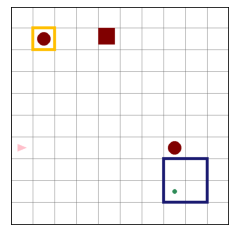

In [22]:
obj_pattern_map = {'$OBJ_0': '$ABS_SHAPE', '$OBJ_1': '$COLOR $SHAPE', '$OBJ_2': '$SHAPE'}
rel_map = {('$OBJ_0', '$OBJ_1'): '$SAME_ROW', ('$OBJ_0', '$OBJ_2'): '$IS_INSIDE'}
grammer_pattern = '$OBJ_0 ^ $OBJ_1 & $OBJ_2'
obj_map = {'$OBJ_0': 'object', '$OBJ_1': 'red square', '$OBJ_2': 'box'}
simulator.sample_situations_from_grounded_grammer(
    grammer_pattern, 
    obj_pattern_map, 
    rel_map, 
    obj_map)